In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import os
import time
import sys
from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect
from PIL import Image, ImageDraw
import pycolmap
#import visualize_model
# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

In [2]:
import torch 
print(torch.__version__)
print(torch.cuda.get_arch_list())

1.9.1+cu111
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [3]:
images = Path('datasets/monarch/')
outputs = Path('outputs/monarch-demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir = outputs / "ref"
''' model location in case of intrinsics locked '''
ref_dir_locked = outputs / "ref_locked"
''' model location in case of intrinsics not locked '''
ref_dir_not_locked = outputs / "ref_dir_not_locked" 

Here we will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [4]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping and refinement
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [5]:
# '''masking of the tractor hood from the images '''
# ''' output => datasets/monarch/{target_folder}/image_name.jpg '''
# def draw_box_around_tractor_hood(image_path, target_folder): 
#     image = Image.open(image_path)
#     w, h = image.size
#     box_x1, box_y1 = 460, 770  # Top-left corner
#     box_x2, box_y2 = 1630, 1080  # Bottom-right corner
#     outline_color = (0, 0, 0)  # Red in RGB format
#     fill_color = (0, 0, 0)  # Black in RGB format
#     draw = ImageDraw.Draw(image)
#     draw.rectangle([box_x1, box_y1, box_x2, box_y2], outline=outline_color, fill=fill_color)
#     directory_path,filename = os.path.split(image_path)
#     parent_directory_path = os.path.dirname(directory_path)
#     target_directory = os.path.join(parent_directory_path, target_folder)
#     os.makedirs(target_directory, exist_ok = True)
#     target_image_path = os.path.join(target_directory,filename)
#     image.save(target_image_path)
#     return target_image_path 

In [6]:
references_left = [str(p.relative_to(images)) for i, p in enumerate((images / 'left/').iterdir())]
references_right = [str(p.relative_to(images)) for i, p in enumerate((images / 'right/').iterdir())]

In [7]:
print(len(references_left))

582


In [8]:
references_left = sorted(references_left, key=lambda x: int(x.split('/')[-1].split('.')[0]))
references_right = sorted(references_right, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [9]:
print(len(references_left))

582


In [10]:
references_left = references_left[40:82] 
references_right = references_right[40:82]
references = references_left + references_right

In [11]:
'''sorting references so that each stereo pair is together in the list '''
references = sorted(references, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [12]:
print(references)

['left/40.jpg', 'right/40.jpg', 'left/41.jpg', 'right/41.jpg', 'left/42.jpg', 'right/42.jpg', 'left/43.jpg', 'right/43.jpg', 'left/44.jpg', 'right/44.jpg', 'left/45.jpg', 'right/45.jpg', 'left/46.jpg', 'right/46.jpg', 'left/47.jpg', 'right/47.jpg', 'left/48.jpg', 'right/48.jpg', 'left/49.jpg', 'right/49.jpg', 'left/50.jpg', 'right/50.jpg', 'left/51.jpg', 'right/51.jpg', 'left/52.jpg', 'right/52.jpg', 'left/53.jpg', 'right/53.jpg', 'left/54.jpg', 'right/54.jpg', 'left/55.jpg', 'right/55.jpg', 'left/56.jpg', 'right/56.jpg', 'left/57.jpg', 'right/57.jpg', 'left/58.jpg', 'right/58.jpg', 'left/59.jpg', 'right/59.jpg', 'left/60.jpg', 'right/60.jpg', 'left/61.jpg', 'right/61.jpg', 'left/62.jpg', 'right/62.jpg', 'left/63.jpg', 'right/63.jpg', 'left/64.jpg', 'right/64.jpg', 'left/65.jpg', 'right/65.jpg', 'left/66.jpg', 'right/66.jpg', 'left/67.jpg', 'right/67.jpg', 'left/68.jpg', 'right/68.jpg', 'left/69.jpg', 'right/69.jpg', 'left/70.jpg', 'right/70.jpg', 'left/71.jpg', 'right/71.jpg', 'left/7

In [13]:
# ''' masking the tractor hood in all the images'''
# ''' returns list of path to the masked images '''
# start_time = time.time()
# target_folder = "masked_images"
# masked_references = [draw_box_around_tractor_hood(p, target_folder) for p in references]
# end_time = time.time()
# elapsed_time = end_time - start_time

# target_path = os.path.join(images, target_folder)

# ''' sorting masked_references sequentially '''
# ''' smf => sorted masked references '''
# #smf = sorted(masked_references, key = lambda x: int(((x.split("/")[-1]).split(".")[0]).split("_")[0]))

# print(f"type(masked_references): {type(masked_references)}")


In [14]:
# smf = []
# for i in range(0, len(references)//2 - 1): 
#     left  = "masked_images/" + str(i) + "_left.jpg"
#     right = "masked_images/" + str(i) + "_right.jpg"
#     smf.append(left)
#     smf.append(right)

In [15]:
# print(f"smf: {smf}")
# print(f"len(smf) : {len(smf)}")

In [16]:
print(references)

['left/40.jpg', 'right/40.jpg', 'left/41.jpg', 'right/41.jpg', 'left/42.jpg', 'right/42.jpg', 'left/43.jpg', 'right/43.jpg', 'left/44.jpg', 'right/44.jpg', 'left/45.jpg', 'right/45.jpg', 'left/46.jpg', 'right/46.jpg', 'left/47.jpg', 'right/47.jpg', 'left/48.jpg', 'right/48.jpg', 'left/49.jpg', 'right/49.jpg', 'left/50.jpg', 'right/50.jpg', 'left/51.jpg', 'right/51.jpg', 'left/52.jpg', 'right/52.jpg', 'left/53.jpg', 'right/53.jpg', 'left/54.jpg', 'right/54.jpg', 'left/55.jpg', 'right/55.jpg', 'left/56.jpg', 'right/56.jpg', 'left/57.jpg', 'right/57.jpg', 'left/58.jpg', 'right/58.jpg', 'left/59.jpg', 'right/59.jpg', 'left/60.jpg', 'right/60.jpg', 'left/61.jpg', 'right/61.jpg', 'left/62.jpg', 'right/62.jpg', 'left/63.jpg', 'right/63.jpg', 'left/64.jpg', 'right/64.jpg', 'left/65.jpg', 'right/65.jpg', 'left/66.jpg', 'right/66.jpg', 'left/67.jpg', 'right/67.jpg', 'left/68.jpg', 'right/68.jpg', 'left/69.jpg', 'right/69.jpg', 'left/70.jpg', 'right/70.jpg', 'left/71.jpg', 'right/71.jpg', 'left/7

In [17]:
references[59]

'right/69.jpg'

In [18]:
features_path_ = extract_features.main(feature_conf, images, image_list= references, feature_path=features)
#match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/02/15 01:31:42 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/84 [00:00<?, ?it/s]

[2024/02/15 01:31:46 hloc INFO] Finished exporting features.


In [19]:
from hloc.extract_features import list_h5_names
h5_feature_names = list_h5_names(features_path_)
print(f"len(h5_feature_names): {len(h5_feature_names)}")
print(h5_feature_names[:10])

len(h5_feature_names): 84
['left/58.jpg', 'right/71.jpg', 'right/52.jpg', 'left/49.jpg', 'right/49.jpg', 'right/51.jpg', 'right/63.jpg', 'left/42.jpg', 'right/72.jpg', 'left/62.jpg']


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively.

In [20]:
# features_path_ = extract_features.main(feature_conf, images, image_list=references_final, feature_path=features)
# #match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
current_path:  /home/skumar/pixel-perfect-sfm
<class 'str'>


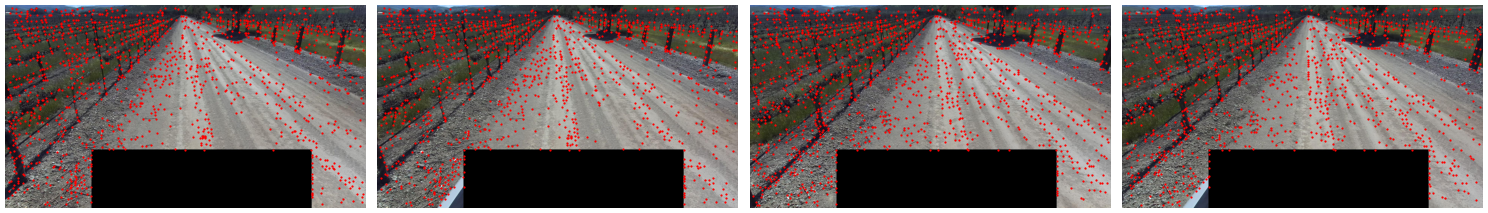

In [21]:
from hloc.utils.viz import plot_keypoints, save_plot
from hloc.utils.io import get_keypoints
import matplotlib.pyplot as plt
import numpy as np
import os

ref_trim_ = references[:4]
plot_images([read_image(images / r) for r in ref_trim_], dpi=50, figsize=4.2)

kps_list_ = [] 
for r in ref_trim_:
    kps = get_keypoints(features_path_, r)
    print(type(kps))
    kps_list_.append(kps)
    
plot_keypoints(kps_list_, colors = "red",  ps = 10)

current_path_ = os.getcwd()

print("current_path: ", current_path_)

print(type(current_path_))

final_path = current_path_ + "/kps.png"


save_plot(final_path)


In [22]:
import collections.abc as collections
isinstance(references, collections.Iterable)

True

In [23]:
pairs_from_exhaustive.stereo_main(sfm_pairs, image_list=references)

[2024/02/15 01:31:53 hloc INFO] Found 326 pairs.


In [24]:
#print("features: ", features)
#print("matches: ", matches)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/02/15 01:31:54 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/326 [00:00<?, ?it/s]

[2024/02/15 01:32:18 hloc INFO] Finished exporting matches.


In [25]:
print(len(list_h5_names(matches)))

326


In [26]:
print(list_h5_names(features))

['left/58.jpg', 'right/71.jpg', 'right/52.jpg', 'left/49.jpg', 'right/49.jpg', 'right/51.jpg', 'right/63.jpg', 'left/42.jpg', 'right/72.jpg', 'left/62.jpg', 'left/52.jpg', 'left/51.jpg', 'left/60.jpg', 'right/40.jpg', 'left/72.jpg', 'right/68.jpg', 'right/42.jpg', 'right/67.jpg', 'left/69.jpg', 'left/57.jpg', 'right/50.jpg', 'right/74.jpg', 'left/75.jpg', 'right/56.jpg', 'left/40.jpg', 'right/58.jpg', 'left/77.jpg', 'right/43.jpg', 'left/68.jpg', 'right/55.jpg', 'right/48.jpg', 'left/41.jpg', 'left/43.jpg', 'left/78.jpg', 'left/70.jpg', 'left/79.jpg', 'right/62.jpg', 'left/46.jpg', 'left/50.jpg', 'right/76.jpg', 'left/44.jpg', 'left/76.jpg', 'left/54.jpg', 'left/80.jpg', 'right/59.jpg', 'right/70.jpg', 'left/67.jpg', 'right/80.jpg', 'left/61.jpg', 'right/46.jpg', 'left/63.jpg', 'right/47.jpg', 'left/47.jpg', 'right/78.jpg', 'left/48.jpg', 'right/81.jpg', 'right/57.jpg', 'left/71.jpg', 'right/61.jpg', 'left/74.jpg', 'left/73.jpg', 'right/65.jpg', 'left/55.jpg', 'right/53.jpg', 'right/41

features: outputs/monarch-demo/features.h5
kp1.shape: (1351, 2)
m.shape: (996, 2)


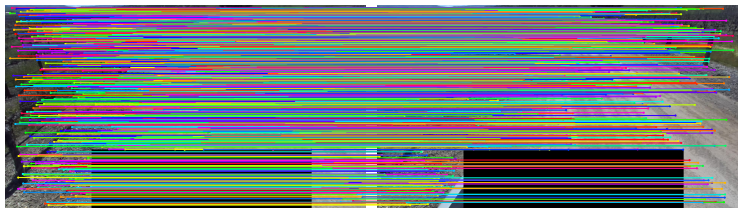

In [27]:
''' script to plot matches between two frames'''
from hloc.utils.viz import plot_matches
from hloc.utils.io import get_matches, get_keypoints
#img1 = images.joinpath(references[0])
#img2 = images.joinpath(references[1])

#print(f"img1 : {img1.as_posix()} img_2: {img2.as_posix()}")

print(f"features: {features}")
kp1 = get_keypoints(features, references[0])
kp2 = get_keypoints(features, references[1])
print(f"kp1.shape: {kp1.shape}")

m, _ = get_matches(matches, references[0], references[1])
print(f"m.shape: {m.shape}")

m1 = np.array([kp1[i] for i in m[:,0]])
m2 = np.array([kp2[i] for i in m[:, 1]])

#print(m1[:10])

plot_images([read_image(images / r) for r in references[:2]], dpi=50, figsize=4.2)
#plot_matches(kp1.transpose, kp2.transpose)
#plot_matches(kp1.transpose, kp2.transpose)
plot_matches(m1, m2)
#plot_matches(m[:,0], m[:,1])
#print(m[:10])
#kp1 = 
#matches, scores = 

Now we run the reconstruction with and without the featuremetric refinement. For this dataset, when computing the dense features, we resize the images such that they are not larger than 1024 pixels.

In [28]:
fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
opencv_camera_params =','.join(map(str, (fx, fy, cx, cy, 0, 0, 0, 0)))

In [29]:
#sfm = PixSfM({"dense_features": {"max_edge": 1024}})


#conf1 = {"dense_features": {"max_edge": 1024}}

conf2 = {
    "BA": {"optimizer": {"refine_focal_length": False,"refine_extra_params": False, "refine_extrinsics": False}},
    "dense_features": {"max_edge":1024}
}

sfm = PixSfM(conf=conf2)



[2024/02/15 01:35:05 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/skumar/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2024/02/15 01:35:05 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1024,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


In [30]:
'''CASE 1 => INITIAL K IS PROVIDED + K IS NOT LOCKED '''
'''
image_options = dict(camera_model='OPENCV', 
                    camera_params=opencv_camera_params,
                    )
mapper_options_locked = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

hloc_args_locked = dict(image_list=references,
                image_options=image_options,
                # mapper_options=mapper_options_locked,
                camera_mode="PER_FOLDER")

K_locked, sfm_outputs_locked = sfm.reconstruction(ref_dir_not_locked, images, sfm_pairs, features, matches, **hloc_args_locked)
'''

'\nimage_options = dict(camera_model=\'OPENCV\', \n                    camera_params=opencv_camera_params,\n                    )\nmapper_options_locked = dict(ba_refine_focal_length=False, \n                      ba_refine_extra_params=False,\n                     ba_refine_principal_point=False)\n\nhloc_args_locked = dict(image_list=references,\n                image_options=image_options,\n                # mapper_options=mapper_options_locked,\n                camera_mode="PER_FOLDER")\n\nK_locked, sfm_outputs_locked = sfm.reconstruction(ref_dir_not_locked, images, sfm_pairs, features, matches, **hloc_args_locked)\n'

In [31]:
'''CASE 2 => INITIAL K IS PROVIDED + K IS LOCKED '''

image_options = dict(camera_model='OPENCV', 
                     camera_params=opencv_camera_params
                    )

mapper_options_one = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

mapper_options_two = dict(ba_refine_focal_length=False, 
                      ba_refine_extra_params=False,
                     ba_refine_principal_point=False)

hloc_args_not_locked = dict(image_list=references,
                image_options=image_options,
                camera_mode="PER_FOLDER",
                mapper_options=mapper_options_two)

#hloc_args_not_locked = dict(image_list=references)

K_locked, sfm_outputs_not_locked = sfm.reconstruction(ref_dir_locked, images, sfm_pairs, features, matches, **hloc_args_not_locked)


[2024/02/15 01:35:13 pixsfm INFO] Building matching graph...
[2024/02/15 01:35:13 pixsfm INFO] Extracting dense features...


  0%|          | 0/84 [00:00<?, ?it/s]

/home/skumar/e6/lib/python3.8/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


[2024/02/15 01:35:24 pixsfm INFO] Computing tracks...
[2024/02/15 01:35:24 pixsfm INFO] # graph nodes: 98213
[2024/02/15 01:35:24 pixsfm INFO] # graph edges: 154905
[2024/02/15 01:35:24 pixsfm INFO] # tracks: 24090
[2024/02/15 01:35:24 pixsfm INFO] Start feature-metric keypoint adjustment.


[2024/02/15 01:35:24 pixsfm WARNING] 38 / 1953 problems have more than 50 keypoints.
         Maximum keypoints in a problem: 84
100%[████████████████████] 98213/98213 [00:08, 11093.7it/s]


[2024/02/15 01:35:33 pixsfm INFO] KA Time: 8.85939s, cost change: 0.0208946 --> 0.0180002


[2024/02/15 01:35:33 hloc INFO] Creating an empty database...
[2024/02/15 01:35:33 hloc INFO] Importing images into the database...
[2024/02/15 01:35:34 hloc INFO] Importing features into the database...


  0%|          | 0/84 [00:00<?, ?it/s]

[2024/02/15 01:35:34 hloc INFO] Importing matches into the database...


  0%|          | 0/326 [00:00<?, ?it/s]

[2024/02/15 01:35:34 hloc INFO] Performing geometric verification of the matches...
[2024/02/15 01:35:37 hloc INFO] Running 3D reconstruction...
[2024/02/15 01:38:54 hloc INFO] Reconstructed 1 model(s).
[2024/02/15 01:38:54 hloc INFO] Largest model is #0 with 84 images.
[2024/02/15 01:38:54 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 84
	num_cameras = 2
	num_points3D = 8152
	num_observations = 31459
	mean_track_length = 3.85905
	mean_observations_per_image = 374.512
	mean_reprojection_error = 1.13986
	num_input_images = 84


[2024/02/15 01:38:54 pixsfm INFO] Extracting references.


100%[████████████████████] 8152/8152 [00:00, 12185.3it/s]


[2024/02/15 01:38:55 pixsfm INFO] Reference Extraction Time: 0.675141s
[2024/02/15 01:38:55 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:09, 11.0213it/s]


[2024/02/15 01:39:04 pixsfm INFO] BA Time: 9.16673s, cost change: 0.020496 --> 0.0202247


In [192]:
'''
e_lw => left camera pose in world frame (4 * 4)
e_rw => right camera pose in world frame (4 * 4)
'''
#def calculate_relative_pose(e_lw, e_rw):
def calculate_relative_pose(e_lw: np.ndarray, e_rw: np.ndarray):
    #print(f"Inside the calculate_relative_pose function")
    from scipy.spatial.transform import Rotation
    e_wl = np.linalg.inv(e_lw)
    #print(f"e_wl: {e_wl}")
    #e_rl = e_rw * np.linalg.inv(e_lw) #right camera in the frame of the left camera
    #e_rl = e_rw * e_wl #right camera in the frame of the left camera
    #print(f"e_rl: {e_rl}")
    e_rl = np.dot(e_rw,np.linalg.inv(e_lw))
    R = e_rl[:3,:3] #extracting the rotation matrix
    dx = e_rl[0,3]
    dy = e_rl[1,3]
    dz = e_rl[2,3]
    dquat = Rotation.from_matrix(R).as_quat()
    #rel_pose =  [dx, dy] + dquat
    rel_pose = [dx,dy,dz]
    for q in dquat: 
        rel_pose.append(q)
    return rel_pose
    #return [dx,dy]
    #print(f"dx: {dx} dy: {dy} dquat: {dquat}")


def cam_extrinsics(img):
    from read_write_model import qvec2rotmat
    R = qvec2rotmat(img.qvec)
    t = img.tvec.reshape(3,-1)
    #print(f"R: {R} t: {t}")
    R_t = np.concatenate((R,t), axis = 1)
    #R_t = np.vstack([np.array([0,0,0,1]), R_t])
    R_t = np.vstack([R_t, np.array([0,0,0,1])])
    return R_t    #  4 * 4 matrix

def calculate_relative_pose_between(left_idx: int, right_idx: int):
    left_img = sparse_img_dict[left_idx]
    right_img = sparse_img_dict[right_idx]
    e_lw = cam_extrinsics(left_img)  #left camera pose w.r.t. world
    e_rw = cam_extrinsics(right_img) #right camera pose w.r.t world
    rel_pose = calculate_relative_pose(e_lw, e_rw)
    return rel_pose


    

In [193]:
# from read_write_model import qvec2rotmat
# qvec = [1,0,0,0]
# R = qvec2rotmat(qvec)
# print(f"R: {R}")

#### Camera positions WITHOUT Rig Bundle Adjustment

In [217]:
from pathlib import Path
#sparse_dir = Path("/home/skumar/stereo_colmap_cli_output/sparse/")
sparse_dir = ref_dir_locked / "hloc"
print(f"sparse_dir: {sparse_dir.as_posix()}")
sparse_images = sparse_dir / "images.bin"
sparse_points3D = sparse_dir / "points3D.bin"
sparse_cameras = sparse_dir / "cameras.bin"

sparse_dir: outputs/monarch-demo/ref_locked/hloc


In [218]:
import sys
sys.path.append("/home/skumar/colmap/scripts/python")
from read_write_model import read_images_binary 
sparse_img_dict = read_images_binary(sparse_images)
print(f"{len(sparse_img_dict.keys())} ==> {sparse_img_dict.keys()}")
print(f"min_key: {min(sparse_img_dict.keys())} mx_key: {max(sparse_img_dict.keys())}")

84 ==> dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])
min_key: 1 mx_key: 84


In [219]:
cam_extrinsics(sparse_img_dict[1])

array([[ 9.99777269e-01,  1.60988575e-03, -2.10432988e-02,
        -1.05086535e-01],
       [-1.63445334e-03,  9.99998003e-01, -1.15033108e-03,
        -2.54289712e+00],
       [ 2.10414048e-02,  1.18446915e-03,  9.99777903e-01,
         5.20909940e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [220]:
# '''pose of left camera in the world frame'''
# e_lw = np.array([[1, 0, 0, -0.06], 
#                 [0, 1, 0, 0],
#                 [0, 0, 1, 0], 
#                 [0, 0, 0, 1]])

# '''pose of right camera in the world frame'''
# e_rw = np.array([[1, 0, 0, 0.06], 
#                 [0, 1, 0, 0],
#                 [0, 0, 1, 0], 
#                 [0, 0, 0, 1]])

# ''' pose of  right camera w.r.t the left camera '''
# #e_rl = calculate_relative_pose(e_lw, e_rw)
# #print(f"e_rl: {e_rl}")
# #e_rl = e_rw * np.linalg.inv(e_lw)
# e_rl = np.dot(e_rw,np.linalg.inv(e_lw))
# #e_rl = np.linalg.inv(e_lw) * e_rw
# print(f"e_rl: {e_rl}")

In [221]:
# print(sparse_img_dict[1])

In [222]:
# from read_write_model import read_cameras_binary 
# sparse_cam_dict = read_cameras_binary(sparse_cameras)
# print(sparse_cam_dict)

In [223]:
# for key in range(1,85): 
#     if key in sparse_img_dict:
#         print(f"{key} => {sparse_img_dict[key].name} camera_id: {sparse_img_dict[key].camera_id}")

In [224]:
import numpy as np
rel_poses = []
num_images = len(sparse_img_dict.keys())
for idx in range(1, num_images // 2 + 1):
    left_img = sparse_img_dict[idx]
    right_img = sparse_img_dict[idx + 42]
    #print(f"left_img_name: {left_img.name} right_img_name: {right_img.name}")
    e_lw = cam_extrinsics(left_img)  #left camera pose w.r.t. world
    e_rw = cam_extrinsics(right_img) #right camera pose w.r.t world
    rel_pose = calculate_relative_pose(e_lw, e_rw)
    rel_poses.append(rel_pose)

In [225]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.notebook_repr_html', True)
df = pd.DataFrame(rel_poses, columns=['dx', 'dy', 'dz', 'qx' , 'qy', 'qz' , 'qw'])
df.style

,dx,dy,dz,qx,qy,qz,qw
0,-0.008100,0.000207,-0.000233,0.000221,0.000073,0.000298,1.000000
1,-0.008173,0.000356,-0.000173,0.000266,0.000071,0.000186,1.000000
2,-0.008271,0.000047,-0.000563,-0.000057,0.000126,-0.000010,1.000000
3,-0.008352,0.000201,-0.000455,0.000137,0.000085,0.000241,1.000000
4,-0.008473,0.000243,-0.000073,0.000256,0.000263,0.000304,1.000000
5,-0.007978,0.000196,-0.000034,0.000215,-0.000144,0.000294,1.000000
6,-0.008270,0.000234,-0.000588,0.000275,-0.000153,0.000406,1.000000
7,-0.007665,0.000172,-0.000374,0.000139,-0.000533,0.000166,1.000000
8,-0.007960,0.000172,-0.001345,0.000201,-0.000615,0.000696,1.000000
9,-0.008235,0.000254,-0.000642,0.000195,-0.000181,0.000294,1.000000


#### Camera poses with Rig Bundle Adjustment

In [226]:
rig_ba_sparse_dir = Path("/home/skumar/rig_stereo_colmap_cli_output/")
print(f"rig_ba_sparse_dir: {rig_ba_sparse_dir.as_posix()}")
rig_ba_sparse_images = rig_ba_sparse_dir / "images.bin"
rig_ba_sparse_points3D = rig_ba_sparse_dir / "points3D.bin"
rig_ba_sparse_cameras = rig_ba_sparse_dir / "cameras.bin"

rig_ba_sparse_dir: /home/skumar/rig_stereo_colmap_cli_output


In [227]:
import sys
sys.path.append("/home/skumar/colmap/scripts/python")
from read_write_model import read_images_binary 
rig_ba_sparse_img_dict = read_images_binary(rig_ba_sparse_images)
print(f"{len(rig_ba_sparse_img_dict.keys())} => {rig_ba_sparse_img_dict.keys()}")

84 => dict_keys([84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])


In [228]:
# import numpy as np
# rig_ba_rel_poses = []
# num_images = len(sparse_img_dict.keys())
# for idx in range(1, num_images // 2 + 1):
#     left_img = rig_ba_sparse_img_dict[idx]
#     right_img = rig_ba_sparse_img_dict[idx + 42]
#     print(f"left_img_name: {left_img.name} right_img_name: {right_img.name}")
#     e_lw = cam_extrinsics(left_img)  #left camera pose w.r.t. world
#     e_rw = cam_extrinsics(right_img) #right camera pose w.r.t world
#     rel_pose = calculate_relative_pose(e_lw, e_rw)
#     rig_ba_rel_poses.append(rel_pose)

In [229]:
# for i in range(0,3): 
#     print(f"{i} => {rig_ba_rel_poses[i]}")

In [230]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.notebook_repr_html', True)
df = pd.DataFrame(rig_ba_rel_poses, columns=['dx', 'dy', 'dz', 'qx' , 'qy', 'qz' , 'qw'])
df.style

,dx,dy,dz,qx,qy,qz,qw
0,0.002426,-6.577848,-27.720957,0.000000,0.000000,-0.000000,1.000000
1,-0.004613,-6.018026,-25.313267,0.000000,-0.000000,-0.000000,1.000000
2,-0.008689,-5.451906,-22.804521,0.000000,-0.000000,-0.000000,1.000000
3,-0.008825,-4.934363,-20.586191,0.000000,-0.000000,-0.000000,1.000000
4,-0.007166,-4.444987,-18.566938,0.000000,-0.000000,-0.000000,1.000000
5,-0.004342,-4.000257,-16.536897,0.000000,-0.000000,0.000000,1.000000
6,-0.003253,-3.539852,-14.585092,0.000000,-0.000000,0.000000,1.000000
7,-0.001700,-3.128075,-12.861581,-0.000000,0.000000,0.000000,1.000000
8,-0.000957,-2.729170,-11.183760,-0.000000,0.000000,0.000000,1.000000
9,-0.001300,-2.357510,-9.564863,-0.000000,0.000000,0.000000,1.000000


# Visualization
To visualize both models together, we rigidly transform the raw reconstruction so that the 3D points common to the two 3D models are aligned.

We now plot the reconstructions side-by-side. We can click on the legend entries to toggle them.

In [ ]:
#curr_directory = os.getcwd()
#dense_model = Path("outputs/mvs/")
from pathlib import Path
import os
import pycolmap
#ply_path = Path("/home/skumar/colmap_output/fused.ply")
#bin_path_1 = Path("/home/skumar/pixel-perfect-sfm/outputs/monarch-demo/ref_dir_not_locked/hloc/")
#bin_path_2 = Path("/home/skumar/pixel-perfect-sfm/outputs/monarch-demo/ref_dir_not_locked/")

#bin_path = Path("/home/skumar/colmap_cli_output/")
locked_path = Path("/home/skumar/colmap_cli_output/")
#not_locked_path = ref_dir_locked
#ply_model = pycolmap.Reconstruction()
#ply_model.import_PLY(ply_path.as_posix())

#bin_model1 = pycolmap.Reconstruction()
#bin_model1.read_binary(bin_path_1.as_posix())

#bin_model2 = pycolmap.Reconstruction()
#bin_model2.read_binary(bin_path_2.as_posix())

#bin_model = pycolmap.Reconstruction()
#bin_model.read_binary(bin_path.as_posix())

locked_model = pycolmap.Reconstruction()
locked_model.read_binary(locked_path.as_posix())

#not_locked_model = pycolmap.Reconstruction()
#not_locked_model.read_binary(not_locked_path.as_posix())


In [ ]:
#print(f"ply_model.summary(): {ply_model.summary()}")
#print(f"bin_model.summary(): {bin_model.summary()}")

print(f"locked_model.summary(): {locked_model.summary()}")
#print(f"not_locked_model.summary(): {not_locked_model.summary()}")


In [ ]:

fig3d = init_figure()
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1.2)
#plot_reconstruction(fig3d, locked_model, color='rgba(255, 0, 0, 0.5)', name="K_not_locked", **args)
#plot_reconstruction(fig3d, K_locked, color='rgba(0, 255, 0, 0.5)', name="K_locked", **args)
plot_reconstruction(fig3d, locked_model, color='rgba(255, 255, 0, 0.5)', name="K_", **args)
#plot_reconstruction(fig3d, locked_model, color='rgba(255,0,0,0.5)', name="locked_model")

fig3d.show()


In [ ]:
sys.path.insert(1, "/home/skumar/colmap/scripts/python/")
points  = read_write_model.read_points3D_binary(Path("/home/skumar/colmap_cli_output/points3D.bin"))

In [ ]:
print(f"type(points): {type(points)}")
#print(f"list(point.keys(): {list(points.keys()}))
key_list = list(points.keys())
print(f"key_list[0:10] : {key_list[0:10]}")

In [ ]:
print(points[155652])

In [ ]:
sys.path.insert(1, "/home/skumar/colmap/scripts/python/")
import read_write_fused_vis
vis_model = read_write_fused_vis.read_fused("/home/skumar/colmap_cli_output/fused.ply", "/home/skumar/colmap_cli_output/fused.ply.vis")

In [ ]:
print(f"type(vis_model) : {type(vis_model)}")
print(f"len(vis_model) : {len(vis_model)}")
vis_model[0]

In [ ]:
#print(f"bin_model1.summary(): {bin_model1.summary()}")
#print(f"bin_model1.summary(): {bin_model1.summary()}")


In [ ]:
import sys
sys.path.append("/home/skumar/colmap/scripts/python")
import read_write_fused_vis
f1 = Path("/home/skumar/colmap_cli_output/fused.ply")
f2 = Path("/home/skumar/colmap_cli_output/fused.ply.vis")
#os.path.exists(f1)
#os.path.exists(f2)
#df = read_write_fused_vis.read_fused(f1,f2)
df = read_write_fused_vis.read_fused(f1.as_posix(),f2.as_posix())
#@r@ead_write_fused_vis.read_fused(f1.as_posix(), f2.as_posix())
print(df[0])

In [ ]:
from read_write_model import read_images_binary
p1 = Path("/home/skumar/colmap_cli_output/images.bin")
os.path.exists(p1)
p2 = Path("/home/skumar/colmap_cli_output/sparse/images.bin")
os.path.exists(p2)
d1 = read_images_binary(p1.as_posix())
d2 = read_images_binary(p2.as_posix())

In [ ]:
print(f"type(d1): {type(d1)}")
print(f"d1.keys(): {d1.keys()}")

In [ ]:
print(type(df))
print(df[0])

In [ ]:
#print(K_not_locked.summary())
print(dense_reconstruction.summary())

In [ ]:
fig3d = init_figure()
args = dict(max_reproj_error=30.0, min_track_length=2, cs=1.2)
#plot_reconstruction(fig3d, K_locked, color='rgba(255, 0, 0, 0.5)', name="K_locked", **args)
plot_reconstruction(fig3d, bin_model, color='rgba(0, 255, 0, 0.5)', name="K_not_locked", **args)

fig3d.show()

In [ ]:
dense_reconstruction.export_PLY("dense_reconstruction.ply")

In [ ]:
max_reproj_error = 3.0
min_track_length=2
rec = dense_reconstruction
p3Ds = [p3D for _, p3D in rec.points3D.items()]
    
xyzs = [p3D.xyz for p3D in p3Ds]
print(xyzs)

In [ ]:
fig3d = init_figure()
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
#plot_reconstruction(fig3d, K_locked_dense, color='rgba(0, 255, 0, 0.5)', name="K_locked", **args)
plot_reconstruction(fig3d, x, color='rgba(255, 255, 0, 0.5)', name="K_not_locked", **args)

fig3d.show()

In [ ]:
fig3d = init_figure()
args = dict(max_reproj_error=30.0, min_track_length=2, cs=1)
plot_reconstruction(fig3d, K_locked_dense, color='rgba(0, 255, 0, 0.5)', name="K_locked", **args)
#plot_reconstruction(fig3d, K_not_locked, color='rgba(255, 255, 0, 0.5)', name="K_not_locked", **args)

fig3d.show()

We can also visualize the detected keypoints (blue) and the final reprojections (red) for a given mapping image. You can drag to zoom in. As you can see, the points were refined by a few pixels at most but the 3D points and camera poses can be refined up to a few meters.

In [ ]:
img = refined.images[refined.reg_image_ids()[0]]
cam = refined.cameras[img.camera_id]
fig = init_image(images / img.name)    
plot_points2D(fig, [p2D.xy for p2D in img.points2D if p2D.has_point3D()])
plot_points2D(fig, cam.world_to_image(img.project(refined)), color='rgba(255, 0, 0, 0.5)')
fig.show()

## PointCloud Segmentation
Segementation of the dense pointcloud

In [ ]:
import sys
sys.path.append("/home/skumar/colmap/scripts/python")

### Analysing Sparse Pointcloud Data

In [ ]:
sparse_dir = Path("/home/skumar/stereo_colmap_cli_output/sparse/")
print(f"sparse_dir: {sparse_dir.as_posix()}")
sparse_images = sparse_dir / "images.bin"
sparse_points3D = sparse_dir / "points3D.bin"
sparse_cameras = sparse_dir / "cameras.bin"

In [ ]:
sparse_model = pycolmap.Reconstruction()
sparse_model.read_binary(sparse_dir.as_posix())
print(f"sparse_model.summary(): {sparse_model.summary()}")

### Loading Dense PointCloud BIN Files

In [ ]:
dense_dir = Path("/home/skumar/stereo_colmap_cli_output")
dense_images = dense_dir / "images.bin"
dense_points3D = dense_dir / "points3D.bin"
dense_cameras = dense_dir / "cameras.bin"

In [ ]:
dense_colmap = pycolmap.Reconstruction()
dense_colmap.read_binary(dense_dir.as_posix())
print(f"summary: {dense_colmap.summary()}")

In [ ]:
fig3d = init_figure()
args = dict(max_reproj_error=3.0, min_track_length=2, cs=20)
#plot_reconstruction(fig3d, dense_colmap, color='rgba(255, 255, 0, 0.5)', name="dense_colmap", **args)
plot_reconstruction(fig3d, dense_colmap, color='rgba(255, 255, 0, 0.5)', name="dense_colmap", **args)
fig3d.show()

### Analysing Dense PointCloud BIN Files

In [ ]:
'''Analysing images.bin'''
from read_write_model import read_images_binary
a = read_images_binary(dense_images)
#a = read_write_model.read_images_binary(dense_images)
print(type(a))
#print(f"min_key: {min(a.keys())} mx_key: {max(a.keys())}")
#print(a[1])
#print(a[1])


In [ ]:
'''Analysing sparse/images.bin'''
from read_write_model import read_images_binary
a = read_images_binary(sparse_images)
#a = read_write_model.read_images_binary(dense_images)
print(type(a))
#print(f"min_key: {min(a.keys())} mx_key: {max(a.keys())}")
#print(a[1])
#print(a[1])
print(a.keys())
print(type(a[29]))
print(a[29])
print(f"dir(a[29]): {dir(a[29])}")

In [ ]:
print(f"dir(dense_colmap): {dir(dense_colmap)}")

In [ ]:
print(f"dir(dense_colmap.images: {dir(dense_colmap.images)}")
#print(f"dir(dense_colmap.images: {dir(dense_colmap.images.items)}")
#print(f"dir(dense_colmap.images: {dir(dense_colmap.images.keys)}")
#print(f"dir(dense_colmap.images: {dir(dense_colmap.images.values)}")

print(f"type(dense_colmap.images: {type(dense_colmap.images)}")
#print(f"type(dense_colmap.images.items: {type(dense_colmap.images.items)}")
#print(f"type(dense_colmap.images.keys: {type(dense_colmap.images.keys)}")
#print(f"type(dense_colmap.images.values: {type(dense_colmap.images.values)}")



In [ ]:
for key, value in dense_colmap.images.items():
    print(f"Key: {key}, Value: {value}")

In [ ]:
key_list = dense_colmap.images.keys()
print(f"len(key_list): {len(key_list)} type(key_list): {type(key_list)}")
#print(key_list[:10])
for k in key_list: 
    print(k)

In [ ]:
for key, value in a.items():
    print(f"key: {key} a[key].id: {a[key].id} a[key].name: {a[key].name}")


In [ ]:
'''Analysing cameras.bin'''
from read_write_model import read_cameras_binary
b = read_cameras_binary(dense_cameras)
print(f"b.keys(): {list(b.keys())}")
for k, v in b.items():
    v_dict  = v._asdict()
    for kk, vv in v_dict.items():
        print(f"{kk}:{vv}")
        
    

In [ ]:
from read_write_model import read_points3D_binary
points3D_bin = read_points3D_binary(dense_points3D)
print(type(c))
print(f"mn: {min(c.keys())} mx: {max(c.keys())}")
print(f"type(c[6904] : {type(c[6904])}")
for k, v in c[6904]._asdict().items():
    print(f"{k}: {v}")

    
    
    


In [ ]:
dense_model = pycolmap.Reconstruction()
dense_model.read_binary(dense_dir.as_posix())

print(f"dense_model.summary(): {dense_model.summary()}")

In [ ]:
from pprint import pprint
print((dense_model.num_reg_images))

### Loading Dense PointCloud PLY Files

In [ ]:
sys.path.append("/home/skumar/colmap/scripts/python/")
from read_write_fused_vis import read_fused

dense_ply = dense_dir / "fused.ply"
dense_ply_vis = dense_dir / "fused.ply.vis"
dense_ply_model = read_fused(dense_ply.as_posix(), dense_ply_vis.as_posix()) 


In [ ]:
print(f"type(dense_ply_model): {type(dense_ply_model)}")

In [ ]:
print(dense_ply_model[0])

In [ ]:
mx_idx = -1
for pt3d in tqdm(dense_ply_model):
    idx_list = pt3d.visible_image_idxs
    #print(f"type(idx_list): {type(idx_list)}")
    mx_idx_in_list = max(idx_list)
    mx_idx = max(mx_idx, mx_idx_in_list)
    #print(f"mx_idx_in_list: {mx_idx_in_list}")
print(f"mx_idx: {mx_idx}")

### Analysing Dense PointCloud PLY files

In [ ]:
print(dense_ply_model[0])

### 3D to 2D mapping Helpers

In [ ]:
import numpy as np 
fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
A = np.array([[fx,0 , cx], [0, fy, cy], [0 , 0, 1]]).astype(np.float64)

def get_camera_matrix(fx, fy, cx, cy):
    return np.array([[fx,0 , cx], [0, fy, cy], [0 , 0, 1]]).astype(np.float64)

'''
A => Camera Matrix => 3 * 3
R => Rotation Matrix => 3 * 3
t => Translation Vector => 3 * 1
P => Projection Matrix => 3 * 4
'''
def getP(A, R, t):
    assert A.shape == (3,3)
    assert R.shape == (3, 3)
    assert t.shape == (3,1)
    R_t = np.concatenate((R,t), axis = 1)
    
    #print(f"A.shape: {A.shape}")
    #print(f"R_t.shape: {R_t.shape}")
    #print(f"t.shape: {t.shape}")
    P = np.dot(A ,R_t)
    return P
'''
coords => 3 * 1 => (x, y, 1)
'''
def mask_value_at(img, coords):
    mask_dir = images / "segmentations"
    segmentation_masks = []
    name = img.split('/')[-1] + ".png"
    mask_name = mask_dir.joinpath(name)
    mask_img = cv2.imread(mask_name.as_posix(), cv2.IMREAD_GRAYSCALE)
    coords = list(coords[:, 0])
    return mask_img[int(coords[0]), int(coords[1])]
    pass

In [ ]:
first5pairs = {k: sparse_img_dict[k] for k in list(sparse_img_dict)[:2]}
print(f"type(sparse_img_dict): {type(sparse_img_dict)}")
print(f"type(first5pairs): {type(first5pairs)}")


In [ ]:
print(list(sparse_img_dict.items())[:2])

In [ ]:
list(sparse_img_dict.keys())[29]

In [ ]:
print(sparse_keys[:2])

In [ ]:
sys.path.append("/home/skumar/colmap/scripts/python")
from read_write_model import qvec2rotmat
from tqdm import tqdm
import cv2
import numpy as np
from progress.bar import Bar
from read_write_model import read_images_binary
#print(f"sample_image: {images_bin[1]}")

no_mask_list = []
mask_dict = {}
mask_mapping_dict = {}

#images_bin = read_images_binary(dense_images)
dense_img_dict = read_images_binary(dense_images)
sparse_img_dict = read_images_binary(sparse_images)

#sparse_img_dict_list = list(sparse_img_dict)

sparse_keys = list(sparse_img_dict.keys())

print(f"sparse_keys: {sparse_keys}")

for point3d in tqdm(dense_ply_model): 
    #print(f"point3d.position: {type(point3d.position)} position[0]: {type(point3d.position[0])}")
    mask_found = False
    mask_list = []
    X = np.append(point3d.position, 1).reshape(4,-1)
    #print(f"X: {X} X.shape: {X.shape} type(X): {type(X)}")
    image_ids = point3d.visible_image_idxs
    #print(f"image_ids: {image_ids}")
    for image_id in image_ids: 
        #curr_img = sparse_img_dict[sparse_keys[image_id]]
        curr_img = sparse_img_dict[image_id + 1]
        R = qvec2rotmat(curr_img.qvec)
        t = curr_img.tvec.reshape(3,-1)
        P = getP(A, R, t)
        x = np.dot(P , X) #project X onto image
        x = x / x[2,0]
        if x[0,0] < 1080 and x[0,0] > 0 and x[1,0] < 1920 and x[1,0] > 0:
            curr_img_mask = mask_value_at(curr_img.name, x)
            mask_found = True
            key = (point3d.position[0], point3d.position[1], point3d.position[2])
            #print(f"key: {key} type(key): {type(key)}")
            mask_dict[key] = curr_img_mask
            if curr_img_mask not in mask_mapping_dict: 
                mask_mapping_dict[curr_img_mask] = []
            mask_mapping_dict[curr_img_mask].append(key)
            #print(f"curr_img_mask: {curr_img_mask}")
            break;
        else:
            pass
    if not mask_found:
        #print(f"Could not find a mask for point : {point3d.position}")
        no_mask_list.append(point3d.position)
    
        

In [ ]:
print(f"len(no_mask_list): {len(no_mask_list)}")

In [ ]:
print(f"len(no_mask_list): {len(no_mask_list)}  {len(no_mask_list)/ len(dense_ply_model) * 100}%")

In [ ]:
color_mask_dict = {0: 'rgb(0,0,0)',
                   1: 'rgb(246,4,228)',
                   2: 'rgb(173, 94, 48)',
                   3: 'rgb(68, 171, 117)',
                   4: 'rgb(162, 122, 174)',
                   5: 'rgb(121, 119, 148)',
                   6: 'rgb(253, 75, 40)',
                   7: 'rgb(170,60,100)',
                   9: 'rgb(170,100,60)'    
}


In [ ]:
mask_dict_list = list(mask_dict.keys())
#print(mask_dict_list)
pts3D_list = []
for pts in mask_dict_list:
    #print(f"pts: {pts} type(pts): {type(pts)} type(pts[0]): {type(pts[0])}")
    pts3D_list.append(np.asarray(pts))
#print(pts3D_list)
pts3D_list = np.asarray(pts3D_list)
#print(pts3D_list)

In [ ]:
invalid_points = no_mask_list
invalid_points = np.asarray(invalid_points)
fig3d = init_figure()
plot_points(fig3d, invalid_points)
fig3d.show()

In [ ]:
fig3d = init_figure()

vine_stem_pts = None

for key in mask_mapping_dict.keys():
    '''if(len(mask_mapping_dict[key]) == 0):
        print("0 value")
        continue
    '''
    if key != 4:
        continue
    print(f"key: {key} color: {color_mask_dict[key]} len(mask_mapping_dict[key] : {len(mask_mapping_dict[key])}")
    pts_list = mask_mapping_dict[key]
    pts = []
    for pt in pts_list: 
        pts.append(np.asarray(pt))
    pts = np.asarray(pts)
    print(f"type(pts) : {type(pts)} pts.shape: {pts.shape}")
    vine_stem_pts = pts 
    #print(f"key: {key} pts.shape: {pts.shape} type(pts): {type(pts)} type(pts[0,0]): {type(pts[0,0])}")
    #plot_points(fig3d, pts, color_mask_dict[key], name=str(key))
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1.2)
plot_reconstruction(fig3d, dense_colmap, color='rgba(255, 255, 0, 0.5)', name="dense_colmap", **args)
#plot_points(fig3d, invalid_points, color='rgba(255,0,0,0.5)', name="invalid_points")

fig3d.show()

In [ ]:
print(f"type(vine_stem_pts): {type(vine_stem_pts)} vine_stem_pts.shape: {vine_stem_pts.shape}")

In [ ]:
#xyz = np.random.rand(100, 3)

def write_as_ply(arr): 
    import open3d as o3d
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(arr)
    #o3d.io.write_point_cloud("./data.ply", pcd)
    o3d.visualization.draw_geometries([pcd])


In [ ]:
#write_as_ply(vine_stem_pts)

### Plotting Segemented Pointcloud

In [ ]:
fig3d = init_figure()
plot_points(fig3d, pts3D_list, name ="k1")
plot_points(fig3d, pts3D_list, name ="k2")
fig3d.show()

In [ ]:
test_map = pycolmap.Reconstruction()
test_map.read_binary("/home/skumar/colmap_cli_output")
plot_reconstruction(test_map?)

### Baseline check

In [ ]:
from read_write_model import read_images_binary
image_dict = read_images_binary(dense_images)
print(image_dict.keys())

In [ ]:
def cam_extrinsics(img):
    from read_write_model import qvec2rotmat
    R = qvec2rotmat(img.qvec)
    t = img.tvec.reshape(3,-1)
    R_t = np.concatenate((R,t), axis = 1)
    R_t = np.vstack([np.array([0,0,0,1]), R_t])
    return R_t    #  4 * 4 matrix
    

In [ ]:
'''
e_lw => left camera pose in world frame (4 * 4)
e_rw => right camera pose in world frame (4 * 4)
'''
def calculate_relative_pose(e_lw, e_rw): 
    from scipy.spatial.transform import Rotation
    e_rl = e_rw * np.linalg.inv(e_lw) #right camera in the frame of the left camera
    R = e_rl[:3,:3] #extracting the rotation matrix
    dx = e_rl[0,3]
    dy = e_rl[1,3]
    dz = e_rl[2,3]
    dquat = Rotation.from_matrix(R).as_quat()
    #rel_pose =  [dx, dy] + dquat
    rel_pose = [dx,dy,dz]
    for q in dquat: 
        rel_pose.append(q)
    return rel_pose
    #return [dx,dy]
    #print(f"dx: {dx} dy: {dy} dquat: {dquat}")

In [107]:
'''pose of cam1 in the frame of rig'''
e_1r = np.array([[1, 0, 0, 0.06], 
                [0, 1, 0, 0],
                [0, 0, 1, 0], 
                [0, 0, 0, 1]])

''' pose of rig in the frame of cam1'''
e_r1 = np.linalg.inv(e_1r)

print(e_r1)

[[ 1.    0.    0.   -0.06]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


In [214]:
np.dot(e_r1 ,e_1r)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
rel_poses = []
for idx in range(0, num_images - 1,2): 
    '''
    if idx > 1:
        break
    '''
    left_img = sparse_img_dict[idx + 1]
    right_img = sparse_img_dict[idx + 2]
    e_lw = cam_extrinsics(left_img)  #left camera pose w.r.t. world
    e_rw = cam_extrinsics(right_img) #right camera pose w.r.t world
    rel_pose = calculate_relative_pose(e_lw, e_rw)
    rel_poses.append(rel_pose)

In [ ]:
print (rel_poses[0])

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.notebook_repr_html', True)
df = pd.DataFrame(rel_poses, columns=['dx', 'dy', 'dz', 'qx' , 'qy', 'qz' , 'qw'])
df.style

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[0, 2] = np.nan
df.style

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/c/c0/La_basilique_du_Sacr%C3%A9-Coeur_au_cr%C3%A9puscule_%28Paris%29_%284147593805%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [ ]:
references_registered = [refined.images[i].name for i in refined.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters. Under the hood, the `QueryLocalizer` takes care of extracting dense features for the query and runs the keypoint and pose adjustments, QKA and QBA. The refinement refines the camera parameters in-place so we can inspect them.

In [ ]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [refined.find_image_with_name(r).image_id for r in references_registered]
conf = {
    "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
    "PnP": {  # initial pose estimation with PnP+RANSAC
        'estimation': {'ransac': {'max_error': 12.0}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    },
    "QBA": {  # query pose refinement
        "optimizer:": {'refine_focal_length': True, 'refine_extra_params': True},
    }
}
dense_features = sfm_outputs["feature_manager"]
localizer = QueryLocalizer(refined, conf, dense_features=dense_features)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches, image_path=images/query)

print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, refined, top_k_db=1)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map, shown here in blue.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, camera, color='rgba(128,128,255,0.5)', name=query, legendgroup="refined")
fig3d.show()